In [1]:
# Instalasi machine Learning Package
import sys
import time
import contextlib
with open('install_ML.log', 'a') as inpt:
    with contextlib.redirect_stdout(inpt):

        # -- Start installation --
        start = time.time()
        !pip install cairosvg
        !pip install padelpy
        !pip install gdown
        !pip install luwiji
        !pip install jcopml
        !pip install chembl_webresource_client

        from luwiji.knn import illustration, demo

        import matplotlib.pyplot as plt
        import seaborn as sns
        import os
        import copy
        from padelpy import padeldescriptor
        import pandas as pd
        import numpy as np

        from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
        from chembl_webresource_client.new_client import new_client
        end = time.time()
        # -- End installation --
print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

+ Time elapsed: 01m 01s


## **Persiapan Data**

### **Rekayasa Data**

Dataset 1 (Lipinsky)

In [2]:
df_lipinsky = pd.read_csv('/content/01_label2class_kras.csv')
df_lipinsky = df_lipinsky.drop("standard_value_norm", axis=1)
df_lipinsky

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2396992,155000.0,inactive,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,243.137,3.28432,2.0,1.0,3.809668
1,CHEMBL3218636,10000.0,inactive,CCCC[C@H]1NC(=O)[C@@H](Cc2ccc3ccccc3c2)NC(=O)[...,1499.798,4.44247,13.0,15.0,5.000000
2,CHEMBL3218638,200.0,active,CC(C)C[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H...,1452.703,-1.14759,19.0,17.0,6.698970
3,CHEMBL3218639,10000.0,inactive,CC1(C)COC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC...,1416.645,1.83787,13.0,16.0,5.000000
4,CHEMBL3218640,10000.0,inactive,CC(C)C[C@@H]1NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](...,1276.500,1.45780,10.0,15.0,5.000000
...,...,...,...,...,...,...,...,...,...
601,CHEMBL5429741,49.2,active,Cc1ccc(S(=O)(=O)Nc2cnc(N3CC=C(c4ccccc4C)CC3)c(...,477.586,4.79956,2.0,5.0,7.308035
602,CHEMBL5413389,32.6,active,Cc1ccccc1C1=CCN(c2ncc(NS(=O)(=O)c3ccc(C(C)C)cc...,491.613,5.30612,2.0,5.0,7.486782
603,CHEMBL5431572,20.9,active,CC(C)c1ccc(S(=O)(=O)Nc2cnc(N3CCCC3)c(C(=O)O)c2...,389.477,3.30420,2.0,5.0,7.679854
604,CHEMBL5425623,35.5,active,Cc1ccc(S(=O)(=O)Nc2cnc(N3CCCC3)c(C(=O)O)c2)c(C)c1,375.450,2.79764,2.0,5.0,7.449772


### *Transformasi Class menjadi numerik ordinal*

In [3]:
# Mapping kelas kategori (class) ke nilai numerik (0,1,2)
mapping = {'active': 0, 'inactive': 1, 'intermediate': 2}
df_lipinsky['class_numeric'] = df_lipinsky['class'].map(mapping)

df_lipinsky

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_numeric
0,CHEMBL2396992,155000.0,inactive,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,243.137,3.28432,2.0,1.0,3.809668,1
1,CHEMBL3218636,10000.0,inactive,CCCC[C@H]1NC(=O)[C@@H](Cc2ccc3ccccc3c2)NC(=O)[...,1499.798,4.44247,13.0,15.0,5.000000,1
2,CHEMBL3218638,200.0,active,CC(C)C[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H...,1452.703,-1.14759,19.0,17.0,6.698970,0
3,CHEMBL3218639,10000.0,inactive,CC1(C)COC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC...,1416.645,1.83787,13.0,16.0,5.000000,1
4,CHEMBL3218640,10000.0,inactive,CC(C)C[C@@H]1NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](...,1276.500,1.45780,10.0,15.0,5.000000,1
...,...,...,...,...,...,...,...,...,...,...
601,CHEMBL5429741,49.2,active,Cc1ccc(S(=O)(=O)Nc2cnc(N3CC=C(c4ccccc4C)CC3)c(...,477.586,4.79956,2.0,5.0,7.308035,0
602,CHEMBL5413389,32.6,active,Cc1ccccc1C1=CCN(c2ncc(NS(=O)(=O)c3ccc(C(C)C)cc...,491.613,5.30612,2.0,5.0,7.486782,0
603,CHEMBL5431572,20.9,active,CC(C)c1ccc(S(=O)(=O)Nc2cnc(N3CCCC3)c(C(=O)O)c2...,389.477,3.30420,2.0,5.0,7.679854,0
604,CHEMBL5425623,35.5,active,Cc1ccc(S(=O)(=O)Nc2cnc(N3CCCC3)c(C(=O)O)c2)c(C)c1,375.450,2.79764,2.0,5.0,7.449772,0


**Dataset 2 (Finger print)**

In [4]:
df_fp = pd.read_csv('/content/df_fp_kras.csv')
df_fp

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
602,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
603,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
604,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Dataset 3 (Menggabungkan Data)**

In [5]:
df_combined = pd.concat([df_lipinsky,df_fp], axis=1)
df_combined.head()

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_numeric,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL2396992,155000.0,inactive,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,243.137,3.28432,2.0,1.0,3.809668,1,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL3218636,10000.0,inactive,CCCC[C@H]1NC(=O)[C@@H](Cc2ccc3ccccc3c2)NC(=O)[...,1499.798,4.44247,13.0,15.0,5.000000,1,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL3218638,200.0,active,CC(C)C[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H...,1452.703,-1.14759,19.0,17.0,6.698970,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL3218639,10000.0,inactive,CC1(C)COC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC...,1416.645,1.83787,13.0,16.0,5.000000,1,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL3218640,10000.0,inactive,CC(C)C[C@@H]1NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](...,1276.500,1.45780,10.0,15.0,5.000000,1,...,0,0,0,0,0,0,0,0,0,0


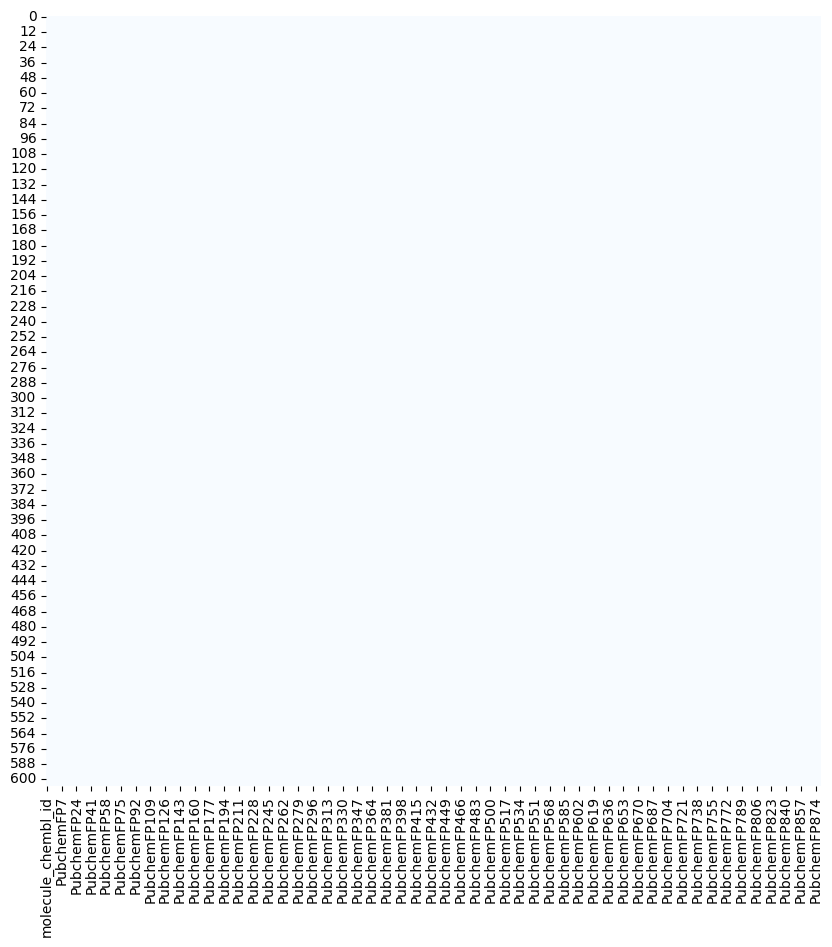

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(df_combined.isna(), cmap="Blues", cbar=False);

## **Preparasi Data**

In [7]:
df = df_combined.drop(columns=["molecule_chembl_id","canonical_smiles","standard_value","class","pIC50"])
df

,MW,LogP,NumHDonors,NumHAcceptors,class_numeric,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,243.137,3.28432,2.0,1.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1499.798,4.44247,13.0,15.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1452.703,-1.14759,19.0,17.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1416.645,1.83787,13.0,16.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1276.500,1.45780,10.0,15.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,477.586,4.79956,2.0,5.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
602,491.613,5.30612,2.0,5.0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
603,389.477,3.30420,2.0,5.0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
604,375.450,2.79764,2.0,5.0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = df.drop(columns='class_numeric')
y = df.class_numeric

In [9]:
X.head()


,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,243.137,3.28432,2.0,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1499.798,4.44247,13.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1452.703,-1.14759,19.0,17.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1416.645,1.83787,13.0,16.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1276.500,1.45780,10.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
y.head()

,class_numeric
0,1
1,1
2,0
3,1
4,1


# **K-Nearest Neighbours**

In [11]:
from sklearn.neighbors import KNeighborsClassifier # Memilih classifier karena berdasarkan target kita (survived) yang juga merupakan kategori
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

In [12]:
knn.score(X,y)

0.995049504950495

## **Splitting**

In [13]:
from sklearn.model_selection import train_test_split
X.shape, y.shape

((606, 885), (606,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((484, 885), (122, 885), (484,), (122,))

## **Fitting Model KNN**

In [15]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [16]:
knn.score(X_train, y_train), knn.score(X_test, y_test)

(1.0, 0.8442622950819673)

## **Cross Validation**

In [17]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=1)
cross_val_score(knn, X, y, cv=3)
cross_val_score(knn, X, y).mean()

0.7492616176669828

## **Improvisasi Data (Rekayasa Fitur)**

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit (X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train), knn.score(X_test_scaled, y_test)

(1.0, 0.8524590163934426)

## **Improvisasi Model**

### **Parameter Tuning**

In [20]:
!pip install tqdm
from tqdm import tqdm

Processing Tuning: 100%|██████████| 25/25 [00:04<00:00,  5.61it/s]


Max test score; 0.8524590163934426
n_neighbor; 3


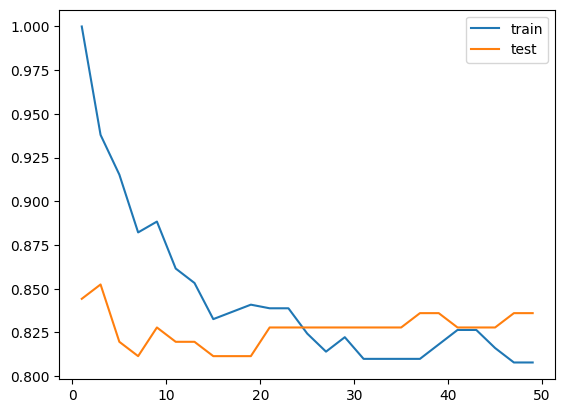

In [21]:
neighbor = range(1,51,2)
train_score = []
test_score = []

for k in tqdm(neighbor, desc="Processing Tuning"):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))

plt.plot(neighbor,train_score, label='train')
plt.plot(neighbor,test_score, label='test')
plt.legend();

print(f"Max test score; {np.max(test_score)}")
print(f"n_neighbor; {neighbor[np.argmax(test_score)]}")

### **Tuning dengan scaling**

Processing Tuning: 100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Max test score; 0.8770491803278688
n_neighbor; 3


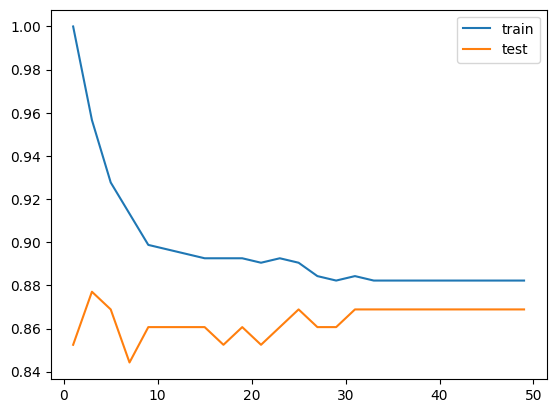

In [22]:
from tqdm import tqdm

neighbor = range(1,51,2)
train_score = []
test_score = []

for k in tqdm(neighbor, desc="Processing Tuning"):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    train_score.append(knn.score(X_train_scaled, y_train))
    test_score.append(knn.score(X_test_scaled, y_test))

plt.plot(neighbor,train_score, label='train')
plt.plot(neighbor,test_score, label='test')
plt.legend();

print(f"Max test score; {np.max(test_score)}")
print(f"n_neighbor; {neighbor[np.argmax(test_score)]}")

### **Tuning n_neighbor dengan weight by distanc**

Processing Tuning: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Max test score; 0.8688524590163934
n_neighbor; 5


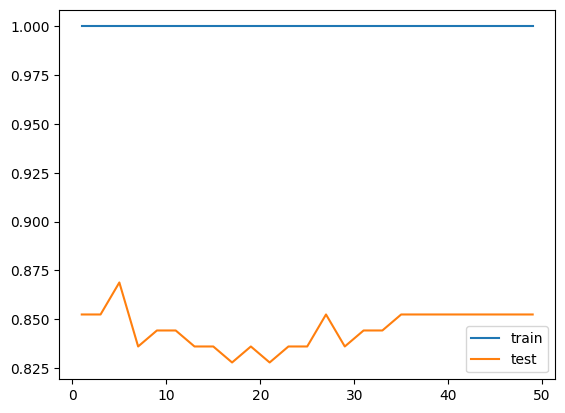

In [23]:
neighbor = range(1,51,2)
train_score = []
test_score = []

for k in tqdm(neighbor, desc="Processing Tuning"):
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(X_train_scaled, y_train)

    train_score.append(knn.score(X_train_scaled, y_train))
    test_score.append(knn.score(X_test_scaled, y_test))

plt.plot(neighbor,train_score, label='train')
plt.plot(neighbor,test_score, label='test')
plt.legend();

print(f"Max test score; {np.max(test_score)}")
print(f"n_neighbor; {neighbor[np.argmax(test_score)]}")

### **Menggunakan Manhattan distance**

Processing Tuning: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Max test score; 0.8688524590163934
n_neighbor; 11


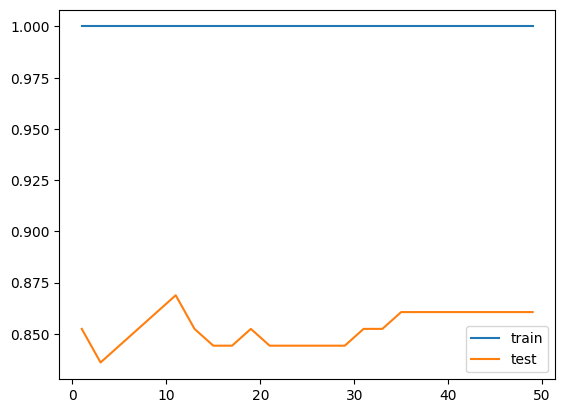

In [24]:
neighbor = range(1,51,2)
train_score = []
test_score = []

for k in tqdm(neighbor, desc="Processing Tuning"):
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance", p=1)
    knn.fit(X_train_scaled, y_train)

    train_score.append(knn.score(X_train_scaled, y_train))
    test_score.append(knn.score(X_test_scaled, y_test))

plt.plot(neighbor,train_score, label='train')
plt.plot(neighbor,test_score, label='test')
plt.legend();

print(f"Max test score; {np.max(test_score)}")
print(f"n_neighbor; {neighbor[np.argmax(test_score)]}")

## **Pipeline**

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

In [26]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler()),
])

In [27]:
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

## **Transformasi Kolom**

In [28]:
from sklearn.compose import ColumnTransformer

In [29]:
X_train.head() #--> cek kolom data train

,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
251,564.665,4.61880,2.0,8.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
394,2064.479,-4.37752,29.0,26.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,521.017,3.32322,1.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,473.964,4.72562,1.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
436,512.017,5.58944,2.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
numeric = ["MW","LogP","NumHDonors","NumHAcceptors"]
categoric = [col for col in X_train.columns if col not in numeric]

In [31]:
preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numeric),
    ("categoric", categorical_pipeline, categoric)
])

## **Pipeline Utama**

In [32]:
from sklearn.neighbors import KNeighborsClassifier
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

In [33]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['MW', 'LogP', 'NumHDonors',
                                                   'NumHAcceptors']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)...
                                                   'PubchemFP6', 'PubchemFP7',
                                                   'PubchemFP8', 'PubchemFP9',
                                                   'PubchemFP10', 'PubchemFP11',
                                                   'PubchemFP12', 'PubchemFP13',
                                                   'PubchemFP14', 'PubchemFP15',
                                                   'PubchemFP16', 'PubchemFP17',
                                                   'PubchemFP18', 'PubchemFP19',
                                                   'PubchemFP20', 'PubchemFP21',
                                                   'PubchemFP22', 'PubchemFP23',
                                                   'PubchemFP24', 'PubchemFP25',
                                                   'PubchemFP26', 'PubchemFP27',
                                                   'PubchemFP28', 'PubchemFP29', ...])])),
                ('algo', KNeighborsClassifier())])

In [34]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.9276859504132231, 0.8688524590163934)

## **Grid search cross validation (GridSearchCV)**

In [35]:
from sklearn.model_selection import GridSearchCV
pipeline.get_params() #--> mengecek parameter apa saja yang dapat dituning

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', MinMaxScaler())]),
                                    ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']),
                                   ('categoric',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinal_encoder',
                                                     OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                    unknown_value=-1))]),
                                    ['PubchemFP0', 'Pubch...
                                     'PubchemFP3', 'PubchemFP4', 'PubchemFP5',
                                     'PubchemFP6', 'Pubch

In [36]:
parameter = {
    "algo__n_neighbors": range(1, 51, 2),
    "algo__weights": ["uniform", "distance"],
    "algo__p": [1,2]
}

model = GridSearchCV(pipeline, parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['MW',
                                                                          'LogP',
                                                                          'NumHDonors',
                                                                          'NumHAcceptors']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_enco...
                                                                          'PubchemFP16',
                                                                          'PubchemFP17',
                                                                          'PubchemFP18',
                                                                          'PubchemFP19',
                                                                          'PubchemFP20',
                                                                          'PubchemFP21',
                                                                          'PubchemFP22',
                                                                          'PubchemFP23',
                                                                          'PubchemFP24',
                                                                          'PubchemFP25',
                                                                          'PubchemFP26',
                                                                          'PubchemFP27',
                                                                          'PubchemFP28',
                                                                          'PubchemFP29', ...])])),
                                       ('algo', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'algo__n_neighbors': range(1, 51, 2),
                         'algo__p': [1, 2],
                         'algo__weights': ['uniform', 'distance']},
             verbose=1)

In [37]:
pd.DataFrame(model.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__n_neighbors,param_algo__p,param_algo__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,1.902551,0.097550,0.675549,0.061008,3,1,distance,"{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__...",0.888889,0.906832,0.919255,0.904992,0.012465,1
7,1.419395,0.151901,0.410841,0.016080,3,2,distance,"{'algo__n_neighbors': 3, 'algo__p': 2, 'algo__...",0.895062,0.900621,0.919255,0.904979,0.010346,2
6,2.006076,0.201143,0.521429,0.143885,3,2,uniform,"{'algo__n_neighbors': 3, 'algo__p': 2, 'algo__...",0.882716,0.906832,0.913043,0.900864,0.013081,3
9,1.340000,0.063647,0.474808,0.033231,5,1,distance,"{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__...",0.882716,0.888199,0.925466,0.898794,0.018993,4
17,1.977269,0.082872,0.667985,0.032807,9,1,distance,"{'algo__n_neighbors': 9, 'algo__p': 1, 'algo__...",0.870370,0.888199,0.931677,0.896749,0.025748,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.043701,0.009489,0.288826,0.005073,43,2,uniform,"{'algo__n_neighbors': 43, 'algo__p': 2, 'algo_...",0.870370,0.869565,0.906832,0.882256,0.017381,95
84,1.702397,0.333273,0.470314,0.090598,43,1,uniform,"{'algo__n_neighbors': 43, 'algo__p': 1, 'algo_...",0.870370,0.869565,0.906832,0.882256,0.017381,95
90,1.762458,0.180516,0.413329,0.099607,45,2,uniform,"{'algo__n_neighbors': 45, 'algo__p': 2, 'algo_...",0.870370,0.869565,0.906832,0.882256,0.017381,95
36,1.367859,0.057354,0.495692,0.010637,19,1,uniform,"{'algo__n_neighbors': 19, 'algo__p': 1, 'algo_...",0.858025,0.869565,0.913043,0.880211,0.023689,99


In [38]:
model.best_params_

{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__weights': 'distance'}

In [39]:
model.score(X_train, y_train), model.score(X_test, y_test)

(1.0, 0.8360655737704918)

# **Ringkasan**

In [40]:
# dataset splitting
X = df.drop(columns='class_numeric')
y = df.class_numeric

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# preprocessor
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", MinMaxScaler())
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric = ["MW","LogP","NumHDonors","NumHAcceptors"]
categoric = [col for col in X_train.columns if col not in numeric]

preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numeric),
    ("categoric", categorical_pipeline,categoric)
])

# pipeline
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

# parameter tuning
parameter = {
    "algo__n_neighbors": np.arange(1,51,2),
    "algo__weights":['uniform', 'distance'],
    "algo__p": [1, 2]
}

model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

# evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.9049919484702094 0.8360655737704918


# **Prediksi**

In [41]:
X_pred = X.iloc[0:10]
X_pred


,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,243.137,3.28432,2.0,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1499.798,4.44247,13.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1452.703,-1.14759,19.0,17.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1416.645,1.83787,13.0,16.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1276.500,1.45780,10.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1486.764,-0.18490,15.0,16.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,453.562,5.13032,3.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,478.528,5.19370,3.0,7.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,520.565,5.13520,3.0,8.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,489.931,5.54420,2.0,4.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X_pred["class_numeric"] = model.predict(X_pred)
X_pred

<ipython-input-42-4bc60750d888>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred["class_numeric"] = model.predict(X_pred)


,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,class_numeric
0,243.137,3.28432,2.0,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1499.798,4.44247,13.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1452.703,-1.14759,19.0,17.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1416.645,1.83787,13.0,16.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1276.500,1.45780,10.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1486.764,-0.18490,15.0,16.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,453.562,5.13032,3.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,478.528,5.19370,3.0,7.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,520.565,5.13520,3.0,8.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,489.931,5.54420,2.0,4.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
# Gunakan seluruh data untuk prediksi
X_pred = X.copy()  # Salin seluruh data fitur
X_pred["class_numeric"] = model.predict(X)  # Tambahkan kolom prediksi
X_pred


,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,class_numeric
0,243.137,3.28432,2.0,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1499.798,4.44247,13.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1452.703,-1.14759,19.0,17.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1416.645,1.83787,13.0,16.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1276.500,1.45780,10.0,15.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,477.586,4.79956,2.0,5.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
602,491.613,5.30612,2.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
603,389.477,3.30420,2.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604,375.450,2.79764,2.0,5.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Akurasi: 0.84
Precision: 0.84
Recall: 0.84
F1-Score: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        94
           1       0.64      0.64      0.64        28

    accuracy                           0.84       122
   macro avg       0.77      0.77      0.77       122
weighted avg       0.84      0.84      0.84       122



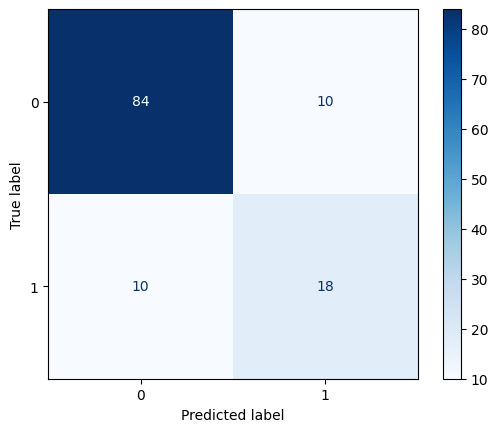

In [44]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

# Prediksi pada data uji
y_pred = model.predict(X_test)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

# Hitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted untuk data tidak seimbang
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Tampilkan metrik
print(f"Akurasi: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Hasil klasifikasi menunjukkan bahwa model memiliki akurasi sebesar 0,84 dengan nilai precision, recall, dan F1-score masing-masing sebesar 0,84. Berdasarkan laporan klasifikasi, kelas 0 memiliki performa yang lebih baik dengan precision, recall, dan F1-score masing-masing sebesar 0,89, sedangkan kelas 1 hanya mencapai nilai sebesar 0,64 untuk ketiga metrik tersebut. Secara keseluruhan, nilai rata-rata makro (macro avg) untuk precision, recall, dan F1-score adalah 0,77, sementara nilai rata-rata berbobot (weighted avg) mencerminkan performa keseluruhan yang sama dengan akurasi, yaitu 0,84. Performa model menunjukkan hasil yang baik, tetapi terdapat ketidakseimbangan performa antara kedua kelas yang perlu diperhatikan, sehingga model dapat diperbaiki dengan menggunakan SMOTE.

In [45]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# pipeline with SMOTE

pipeline = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("algo", KNeighborsClassifier())
])

# parameter tuning
parameter = {
    "algo__n_neighbors": np.arange(1, 51, 2),
    "algo__weights": ['uniform', 'distance'],
    "algo__p": [1, 2]
}

model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

# evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


{'algo__n_neighbors': 33, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.9070751220509674 0.8524590163934426


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


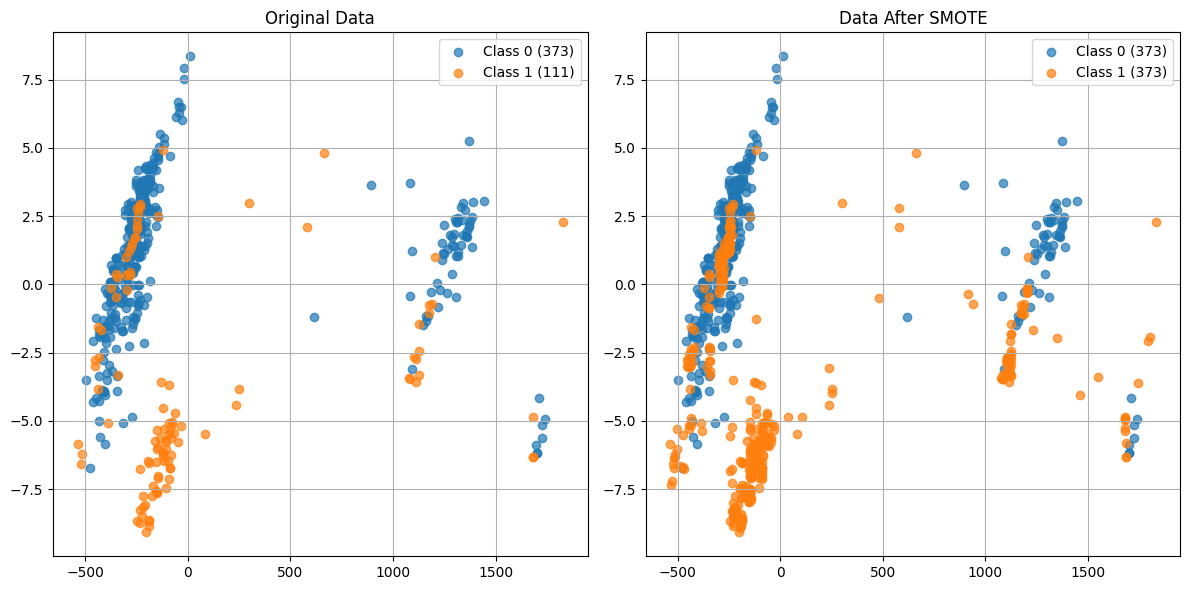

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from collections import Counter

# Terapkan SMOTE untuk menghasilkan data sintetis
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Visualisasi data sebelum dan sesudah SMOTE
def visualize_smote(X_original, y_original, X_resampled, y_resampled):
    # Jika fitur lebih dari dua, gunakan PCA untuk reduksi dimensi
    if X_original.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X_original_2d = pca.fit_transform(X_original)
        X_resampled_2d = pca.transform(X_resampled)
    else:
        X_original_2d = X_original
        X_resampled_2d = X_resampled

    # Hitung distribusi kelas sebelum dan sesudah
    original_count = Counter(y_original)
    resampled_count = Counter(y_resampled)

    # Plot data asli
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for label in original_count.keys():
        plt.scatter(
            X_original_2d[y_original == label, 0],
            X_original_2d[y_original == label, 1],
            label=f"Class {label} ({original_count[label]})",
            alpha=0.7
        )
    plt.title("Original Data")
    plt.legend()
    plt.grid()

    # Plot data setelah SMOTE
    plt.subplot(1, 2, 2)
    for label in resampled_count.keys():
        plt.scatter(
            X_resampled_2d[y_resampled == label, 0],
            X_resampled_2d[y_resampled == label, 1],
            label=f"Class {label} ({resampled_count[label]})",
            alpha=0.7
        )
    plt.title("Data After SMOTE")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
visualize_smote(X_train, y_train, X_resampled, y_resampled)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

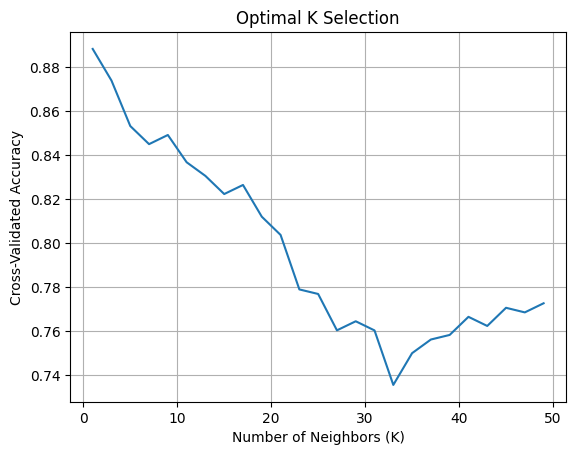

In [47]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

k_values = np.arange(1, 51, 2)
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    pipeline = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("algo", knn)
    ])
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=3)
    scores.append(cv_score.mean())

plt.plot(k_values, scores)
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Optimal K Selection")
plt.grid()
plt.show()
